In [1]:
import numpy as np
from pathlib import Path
from PIL import Image
from torch.utils.data import DataLoader, random_split
import torch
from torch import optim
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import logging
from evaluate import evaluate
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
from collections import OrderedDict

#from model.unet.unet_model import UNet
#from model.segnet.segnet_model import SegNet
#from torchvision.models.segmentation import deeplabv3_resnet101 as DeepLabv3
from model.ensemblenet_model import EnsembleNet


from utils.dice_score import dice_loss
from utils.data_load import KittiDataset
from torchsummaryX import summary

In [2]:
Val_Percent = 0.3
Scale_Percent = 1.0
Batch_Size = 8
learning_rate = 0.0001
Pin_Memory = False
epochs = 50

#Image_Size = [384, 1242]
Image_Size = [384, 1216]
#Image_Size = [384,384]
Gradient_Clipping = 0.8

#Num_Class = 31
#Num_Class = 21
Num_Class = 2
Num_Channel = 3
amp = True

Model_Name = 'segnet'


Img_Path =  'data/data_road/training/image_2'
Mask_Path =  'data/data_road/training/semantic'

save_checkpoint = False
checkpoint_dir = '../trained'
batch_size = Batch_Size

In [3]:
dirImg = Path(Img_Path)
dirMask = Path(Mask_Path)

dir_checkpoint = Path(checkpoint_dir)

train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        #A.VerticalFlip(p=0.5),
        A.Rotate(limit=30, p=0.5),
        #A.RandomBrightnessContrast(p=0.5),
        #A.RandomGamma(p=0.5),
        #A.RandomSnow(p=0.5),
        #A.RandomRain(p=0.5),
        #A.RandomFog(p=0.5),
        #A.RandomSunFlare(p=0.5),
        A.RandomShadow(p=0.5),
        #A.RandomToneCurve(p=0.5),
        #A.GaussNoise(p=0.5),
        #A.Emboss(p=0.5),  # IAAEmboss 대신 Emboss 사용
        #A.Perspective(p=0.5),  # IAAPerspective 대신 Perspective 사용
        #A.CLAHE(p=0.5)
])

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent)
#datasets =  KittiDataset(dirImg, dirMask, Image_Size, Scale_Percent, train_transform)
n_val = int(len(datasets) * Val_Percent)
n_train = len(datasets) - n_val
train_set, val_set = random_split(datasets, [n_train, n_val], generator=torch.Generator().manual_seed(0))

loader_args = dict(batch_size=Batch_Size, num_workers= os.cpu_count(), pin_memory=Pin_Memory)
train_loader = DataLoader(train_set, shuffle=True, drop_last = True, **loader_args)
val_loader = DataLoader(val_set, shuffle=False, drop_last=True, **loader_args)

100%|██████████| 289/289 [00:00<00:00, 849.46it/s] 


In [6]:
model = EnsembleNet(Model_Name, Num_Channel, Num_Class)
model = model.to(memory_format=torch.channels_last, device = device)

In [7]:
# 4. Set up the optimizer, the loss, the learning rate scheduler and the loss scaling for AMP
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)
#optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-8)
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=1e-8, momentum=0.9)

if 'ensemble_voting' in Model_Name:
    unet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    segnet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    enet_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    voting_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score
    
else:
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)  # goal: maximize Dice score

grad_scaler = torch.cuda.amp.GradScaler(enabled=amp)
criterion = nn.CrossEntropyLoss()
global_step = 0

In [8]:
def calculate_loss(pred, true_masks, nclass, multiclass):
    loss = criterion(pred, true_masks)
    loss += dice_loss(
        F.softmax(pred, dim=1).float(),
        F.one_hot(true_masks, nclass).permute(0, 3, 1, 2).float(),
        multiclass=multiclass
    )
    return loss


def forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, model_name):
    with torch.autocast(device.type if device.type != 'mps' else 'cpu', enabled=amp):
        if model_name == 'ensemble_voting':
            unet_pred, segnet_pred, enet_pred = model(images)
            #deeplab_pred = deeplab_pred['out']
        else:
            masks_pred = model(images)
            if isinstance(masks_pred, OrderedDict):
                masks_pred = masks_pred['out']

        try:
            mn_cls = model.n_classes
        except:
            mn_cls = model.classifier[-1].out_channels


        if model_name == 'ensemble_voting':
            unet_loss = calculate_loss(unet_pred, true_masks, mn_cls, multiclass=True)
            segnet_loss = calculate_loss(segnet_pred, true_masks, mn_cls, multiclass=True)
            enet_loss = calculate_loss(enet_pred, true_masks, mn_cls, multiclass=True)
            
        else:
            loss = calculate_loss(masks_pred, true_masks, mn_cls, multiclass=True)

    
    optimizer.zero_grad(set_to_none=True)
    if model_name == 'ensemble_voting':
        for pred, loss in zip([unet_pred, segnet_pred, enet_pred], [unet_loss, segnet_loss, enet_loss]):
            grad_scaler.scale(loss).backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
            grad_scaler.step(optimizer)
            grad_scaler.update()
        
        return model, unet_loss, segnet_loss, enet_loss
    else:
        optimizer.zero_grad(set_to_none=True)
        grad_scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), Gradient_Clipping)
        grad_scaler.step(optimizer)
        grad_scaler.update()
        
        return model, loss


In [9]:
valScore_list1 = []
TrainLoss_list1 = []

valScore_list2 = []
TrainLoss_list2 = []

valScore_list3 = []
TrainLoss_list3 = []

valScore_list4 = []
TrainLoss_list4 = []

val_losses = []
val_accs = []
val_mious = []

# 5. Begin training
for epoch in range(1, epochs + 1):
    model.train()
    epoch_loss = 0
    epoch_unet_loss = 0
    epoch_segnet_loss = 0
    epoch_enet_loss = 0
    epoch_voting_loss = 0
    
    with tqdm(total=n_train, desc=f'Epoch {epoch}/{epochs}', unit='img') as pbar:
        for batch in train_loader:
            images, true_masks = batch['image'], batch['mask']

            images = images.to(device=device, dtype=torch.float32, memory_format=torch.channels_last)
            true_masks = true_masks.to(device=device, dtype=torch.long)

                
            result = forward_and_backward(model, images, true_masks, amp, optimizer, grad_scaler, Model_Name)
            
            if len(result) == 4:
                model, unet_loss, segnet_loss, enet_loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_unet_loss += unet_loss.item()
                epoch_segnet_loss += segnet_loss.item()
                epoch_enet_loss += enet_loss.item()
                vot_loss = ((unet_loss.item() + segnet_loss.item() + enet_loss.item()) /3)
                epoch_voting_loss += vot_loss
                
                
            elif len(result) == 2:
                model, loss = result
                
                pbar.update(images.shape[0])
                global_step += 1
                epoch_loss += loss.item()


        print('***')
        if len(result) == 4:
            print('Unet Loss: {}     Segnet Loss: {}     Enet Loss: {}'.format(unet_loss, segnet_loss, enet_loss))
            print('Voting Loss: {}'.format(vot_loss))
            
            
        elif len(result) == 2:
            print('{} Loss: {}'.format(Model_Name, loss))

        # Evaluation round
        division_step = (n_train // (5 * batch_size))
        if division_step > 0:
            #if global_step % division_step == 0:
            if len(result) == 4:
                unet_val_score, segnet_val_score, enet_val_score, voting_val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                unet_scheduler.step(unet_val_score)
                segnet_scheduler.step(segnet_val_score)
                enet_scheduler.step(enet_val_score)
                voting_scheduler.step(voting_val_score)
                
                valScore_list1.append(unet_val_score)
                TrainLoss_list1.append(unet_loss)
                valScore_list2.append(segnet_val_score)
                TrainLoss_list2.append(segnet_loss)                
                valScore_list3.append(enet_val_score)
                TrainLoss_list3.append(enet_loss)
                valScore_list4.append(voting_val_score)
                TrainLoss_list4.append(vot_loss)
                
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)
                
                print('---')
                print('Unet Validation Dice Score: {}     Segnet Validation Dice Score: {}     Enet Validation Dice Score: {}'.format(unet_val_score, segnet_val_score, enet_val_score))
                
                print('Ensemble Voting Validation Dice Loss: {}'.format(val_loss))
                print('Ensemble Voting Validation Pixel Accuracy: {} '.format(val_acc))
                print('Ensemble Voting Validation MIoU: {}'.format(val_miou))                
                print('Ensemble Voting Validation Dice Score: {} '.format(voting_val_score))
                
            else:
                val_score, val_loss, val_acc, val_miou = evaluate(model, val_loader, criterion, device, Model_Name, amp)
                
                
                
                scheduler.step(val_score)
                
                print('---')
                print('{} Validation Dice Loss: {}'.format(Model_Name, val_loss))   
                print('{} Validation Pixel Accuracy: {}'.format(Model_Name, val_acc))
                print('{} Validation MIoU: {}'.format(Model_Name, val_miou))
                print('{} Validation Dice Score: {}'.format(Model_Name, val_score))
                
            
                valScore_list1.append(val_score.cpu().detach().numpy())
                TrainLoss_list1.append(loss.cpu().detach().numpy())
                val_losses.append(val_loss)
                val_accs.append(val_acc)
                val_mious.append(val_miou)

                #valScore_list.append(val_score)
                #TrainLoss_list.append(loss)
                #print('Validation Dice score: {}'.format(val_score))
                                
        
    if save_checkpoint:
        Path(dir_checkpoint).mkdir(parents=True, exist_ok=True)
        torch.save(model.state_dict(), str(dir_checkpoint / 'checkpoint_epoch{}.pth'.format(epoch + 1)))

Epoch 1/50:  99%|█████████▊| 200/203 [00:08<00:00, 42.52img/s]

***
segnet Loss: 0.48105302453041077


Epoch 1/50:  99%|█████████▊| 200/203 [00:11<00:00, 18.05img/s]


---
segnet Validation Dice Loss: 0.41357511281967163
segnet Validation Pixel Accuracy: 0.8505867405941612
segnet Validation MIoU: 0.4252977494176336
segnet Validation Dice Score: 1.7945034414879046e-05


Epoch 2/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.21img/s]

***
segnet Loss: 0.3755287826061249


Epoch 2/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.40img/s]


---
segnet Validation Dice Loss: 0.30457407236099243
segnet Validation Pixel Accuracy: 0.9315421121162281
segnet Validation MIoU: 0.7912284752696485
segnet Validation Dice Score: 0.7834444642066956


Epoch 3/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.43img/s]

***
segnet Loss: 0.3293437957763672


Epoch 3/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.75img/s]


---
segnet Validation Dice Loss: 0.29474902153015137
segnet Validation Pixel Accuracy: 0.9389744808799342
segnet Validation MIoU: 0.809488327002262
segnet Validation Dice Score: 0.7894086241722107


Epoch 4/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.17img/s]

***
segnet Loss: 0.24898196756839752


Epoch 4/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.52img/s]


---
segnet Validation Dice Loss: 0.27813735604286194
segnet Validation Pixel Accuracy: 0.9408906635485197
segnet Validation MIoU: 0.7998930648178242
segnet Validation Dice Score: 0.8328266143798828


Epoch 5/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.11img/s]

***
segnet Loss: 0.24776184558868408


Epoch 5/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.50img/s]


---
segnet Validation Dice Loss: 0.26275789737701416
segnet Validation Pixel Accuracy: 0.9457740114446271
segnet Validation MIoU: 0.8236834711818977
segnet Validation Dice Score: 0.8376688957214355


Epoch 6/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.04img/s]

***
segnet Loss: 0.2631337642669678


Epoch 6/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.87img/s]


---
segnet Validation Dice Loss: 0.26302874088287354
segnet Validation Pixel Accuracy: 0.944698132966694
segnet Validation MIoU: 0.8156415875028749
segnet Validation Dice Score: 0.8219112753868103


Epoch 7/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.00img/s]

***
segnet Loss: 0.2544098496437073


Epoch 7/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.46img/s]


---
segnet Validation Dice Loss: 0.24401623010635376
segnet Validation Pixel Accuracy: 0.9468335603412829
segnet Validation MIoU: 0.8235838098771032
segnet Validation Dice Score: 0.8579652905464172


Epoch 8/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.16img/s]

***
segnet Loss: 0.25827422738075256


Epoch 8/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.28img/s]


---
segnet Validation Dice Loss: 0.21902935206890106
segnet Validation Pixel Accuracy: 0.9618653414542215
segnet Validation MIoU: 0.8645836466399903
segnet Validation Dice Score: 0.8380468487739563


Epoch 9/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.07img/s]

***
segnet Loss: 0.19832691550254822


Epoch 9/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.58img/s]


---
segnet Validation Dice Loss: 0.23282767832279205
segnet Validation Pixel Accuracy: 0.9585908588610197
segnet Validation MIoU: 0.855928214108022
segnet Validation Dice Score: 0.8302238583564758


Epoch 10/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.03img/s]

***
segnet Loss: 0.37120068073272705


Epoch 10/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.20img/s]


---
segnet Validation Dice Loss: 0.2158113569021225
segnet Validation Pixel Accuracy: 0.9587011504591557
segnet Validation MIoU: 0.8570426365064392
segnet Validation Dice Score: 0.8293930292129517


Epoch 11/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.81img/s]

***
segnet Loss: 0.26950138807296753


Epoch 11/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.37img/s]


---
segnet Validation Dice Loss: 0.195940300822258
segnet Validation Pixel Accuracy: 0.9675084164268092
segnet Validation MIoU: 0.8848042020262614
segnet Validation Dice Score: 0.8444694876670837


Epoch 12/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.88img/s]

***
segnet Loss: 0.22118690609931946


Epoch 12/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.43img/s]


---
segnet Validation Dice Loss: 0.19612911343574524
segnet Validation Pixel Accuracy: 0.9699027078193531
segnet Validation MIoU: 0.8898057676121374
segnet Validation Dice Score: 0.8720158934593201


Epoch 13/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.76img/s]

***
segnet Loss: 0.23081693053245544


Epoch 13/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.78img/s]


---
segnet Validation Dice Loss: 0.19995789229869843
segnet Validation Pixel Accuracy: 0.9657723945483827
segnet Validation MIoU: 0.8813677149448893
segnet Validation Dice Score: 0.8976640701293945


Epoch 14/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.60img/s]

***
segnet Loss: 0.20258167386054993


Epoch 14/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.62img/s]


---
segnet Validation Dice Loss: 0.20058999955654144
segnet Validation Pixel Accuracy: 0.9708605314555921
segnet Validation MIoU: 0.893411285440762
segnet Validation Dice Score: 0.9006439447402954


Epoch 15/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.68img/s]

***
segnet Loss: 0.19863811135292053


Epoch 15/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.19img/s]


---
segnet Validation Dice Loss: 0.1888384371995926
segnet Validation Pixel Accuracy: 0.9700336121676261
segnet Validation MIoU: 0.8940257046865667
segnet Validation Dice Score: 0.9004086852073669


Epoch 16/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.71img/s]

***
segnet Loss: 0.20709967613220215


Epoch 16/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.18720188736915588
segnet Validation Pixel Accuracy: 0.973874008446409
segnet Validation MIoU: 0.9035924781666789
segnet Validation Dice Score: 0.8999771475791931


Epoch 17/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.70img/s]

***
segnet Loss: 0.22968557476997375


Epoch 17/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.95img/s]


---
segnet Validation Dice Loss: 0.1754382848739624
segnet Validation Pixel Accuracy: 0.9764752304344847
segnet Validation MIoU: 0.9140417520343735
segnet Validation Dice Score: 0.9062207341194153


Epoch 18/50:  99%|█████████▊| 200/203 [00:06<00:00, 42.11img/s]

***
segnet Loss: 0.1834658980369568


Epoch 18/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.1761435717344284
segnet Validation Pixel Accuracy: 0.9750550922594572
segnet Validation MIoU: 0.9095745644335085
segnet Validation Dice Score: 0.9053603410720825


Epoch 19/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.65img/s]

***
segnet Loss: 0.1683703362941742


Epoch 19/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.68img/s]


---
segnet Validation Dice Loss: 0.1748773455619812
segnet Validation Pixel Accuracy: 0.9752612197608278
segnet Validation MIoU: 0.9106135570787575
segnet Validation Dice Score: 0.9054644703865051


Epoch 20/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.17img/s]

***
segnet Loss: 0.1644417941570282


Epoch 20/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.04img/s]


---
segnet Validation Dice Loss: 0.18012332916259766
segnet Validation Pixel Accuracy: 0.9723813240988213
segnet Validation MIoU: 0.9021110231117615
segnet Validation Dice Score: 0.9063960313796997


Epoch 21/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.28img/s]

***
segnet Loss: 0.26379120349884033


Epoch 21/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.18img/s]


---
segnet Validation Dice Loss: 0.16469751298427582
segnet Validation Pixel Accuracy: 0.980874312551398
segnet Validation MIoU: 0.9290918324003583
segnet Validation Dice Score: 0.9088223576545715


Epoch 22/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.61img/s]

***
segnet Loss: 0.21318581700325012


Epoch 22/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.76img/s]


---
segnet Validation Dice Loss: 0.1916746199131012
segnet Validation Pixel Accuracy: 0.9695354260896382
segnet Validation MIoU: 0.8862116723431082
segnet Validation Dice Score: 0.9077553749084473


Epoch 23/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.28img/s]

***
segnet Loss: 0.18851858377456665


Epoch 23/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.43img/s]


---
segnet Validation Dice Loss: 0.17296196520328522
segnet Validation Pixel Accuracy: 0.975311279296875
segnet Validation MIoU: 0.9107449991639489
segnet Validation Dice Score: 0.90949946641922


Epoch 24/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.56img/s]

***
segnet Loss: 0.2413669228553772


Epoch 24/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.99img/s]


---
segnet Validation Dice Loss: 0.16104242205619812
segnet Validation Pixel Accuracy: 0.9805718137506854
segnet Validation MIoU: 0.9281867504736554
segnet Validation Dice Score: 0.8967879414558411


Epoch 25/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.52img/s]

***
segnet Loss: 0.16802754998207092


Epoch 25/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.59img/s]


---
segnet Validation Dice Loss: 0.1731189787387848
segnet Validation Pixel Accuracy: 0.9762380499588815
segnet Validation MIoU: 0.9124701427620614
segnet Validation Dice Score: 0.9107295870780945


Epoch 26/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.42img/s]

***
segnet Loss: 0.16984158754348755


Epoch 26/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.30img/s]


---
segnet Validation Dice Loss: 0.1660132110118866
segnet Validation Pixel Accuracy: 0.9784826981393915
segnet Validation MIoU: 0.9207613517160942
segnet Validation Dice Score: 0.9143838882446289


Epoch 27/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.56img/s]

***
segnet Loss: 0.23656035959720612


Epoch 27/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.33img/s]


---
segnet Validation Dice Loss: 0.17346397042274475
segnet Validation Pixel Accuracy: 0.9749630041289747
segnet Validation MIoU: 0.9067067175123804
segnet Validation Dice Score: 0.9095679521560669


Epoch 28/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.73img/s]

***
segnet Loss: 0.1723771095275879


Epoch 28/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.16739383339881897
segnet Validation Pixel Accuracy: 0.9766666345429003
segnet Validation MIoU: 0.9149152277742003
segnet Validation Dice Score: 0.9088506102561951


Epoch 29/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.80img/s]

***
segnet Loss: 0.15837809443473816


Epoch 29/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.35img/s]


---
segnet Validation Dice Loss: 0.16532135009765625
segnet Validation Pixel Accuracy: 0.9782337389494243
segnet Validation MIoU: 0.9192988559333893
segnet Validation Dice Score: 0.9120780825614929


Epoch 30/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.88img/s]

***
segnet Loss: 0.19830293953418732


Epoch 30/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.51img/s]


---
segnet Validation Dice Loss: 0.1698034703731537
segnet Validation Pixel Accuracy: 0.9765582168311403
segnet Validation MIoU: 0.9125665246698199
segnet Validation Dice Score: 0.9129244089126587


Epoch 31/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.61img/s]

***
segnet Loss: 0.20445334911346436


Epoch 31/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.15img/s]


---
segnet Validation Dice Loss: 0.16575542092323303
segnet Validation Pixel Accuracy: 0.9785991467927632
segnet Validation MIoU: 0.9200711513048965
segnet Validation Dice Score: 0.9163161516189575


Epoch 32/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.66img/s]

***
segnet Loss: 0.1547020673751831


Epoch 32/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.38img/s]


---
segnet Validation Dice Loss: 0.15800705552101135
segnet Validation Pixel Accuracy: 0.98167365893983
segnet Validation MIoU: 0.9322949237413329
segnet Validation Dice Score: 0.9187049865722656


Epoch 33/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.64img/s]

***
segnet Loss: 0.17041151225566864


Epoch 33/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.79img/s]


---
segnet Validation Dice Loss: 0.1637919843196869
segnet Validation Pixel Accuracy: 0.9789889151589912
segnet Validation MIoU: 0.9225463192589123
segnet Validation Dice Score: 0.9162002801895142


Epoch 34/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.70img/s]

***
segnet Loss: 0.18517112731933594


Epoch 34/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.73img/s]


---
segnet Validation Dice Loss: 0.16296173632144928
segnet Validation Pixel Accuracy: 0.9790103310032895
segnet Validation MIoU: 0.9226788548543376
segnet Validation Dice Score: 0.9177867770195007


Epoch 35/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.61img/s]

***
segnet Loss: 0.17480583488941193


Epoch 35/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.16img/s]


---
segnet Validation Dice Loss: 0.16545724868774414
segnet Validation Pixel Accuracy: 0.9792718720017818
segnet Validation MIoU: 0.922201443625134
segnet Validation Dice Score: 0.9158622622489929


Epoch 36/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.61img/s]

***
segnet Loss: 0.16591739654541016


Epoch 36/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
segnet Validation Dice Loss: 0.15921878814697266
segnet Validation Pixel Accuracy: 0.9812027780633223
segnet Validation MIoU: 0.9299096768525095
segnet Validation Dice Score: 0.9195733070373535


Epoch 37/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.42img/s]

***
segnet Loss: 0.1787758469581604


Epoch 37/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.25img/s]


---
segnet Validation Dice Loss: 0.16421937942504883
segnet Validation Pixel Accuracy: 0.9786805270010965
segnet Validation MIoU: 0.92090430184588
segnet Validation Dice Score: 0.9186563491821289


Epoch 38/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.48img/s]

***
segnet Loss: 0.14697764813899994


Epoch 38/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.20img/s]


---
segnet Validation Dice Loss: 0.16527646780014038
segnet Validation Pixel Accuracy: 0.9778851960834704
segnet Validation MIoU: 0.9185444333349073
segnet Validation Dice Score: 0.9183524250984192


Epoch 39/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.60img/s]

***
segnet Loss: 0.18173770606517792


Epoch 39/50:  99%|█████████▊| 200/203 [00:09<00:00, 21.56img/s]


---
segnet Validation Dice Loss: 0.1759609878063202
segnet Validation Pixel Accuracy: 0.9748331705729166
segnet Validation MIoU: 0.9077350819304819
segnet Validation Dice Score: 0.9166297316551208


Epoch 40/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.69img/s]

***
segnet Loss: 0.16812972724437714


Epoch 40/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.64img/s]


---
segnet Validation Dice Loss: 0.16881759464740753
segnet Validation Pixel Accuracy: 0.9767616673519737
segnet Validation MIoU: 0.9142752236307113
segnet Validation Dice Score: 0.9180728197097778


Epoch 41/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.57img/s]

***
segnet Loss: 0.15864355862140656


Epoch 41/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.34img/s]


---
segnet Validation Dice Loss: 0.1602904200553894
segnet Validation Pixel Accuracy: 0.9803255315412555
segnet Validation MIoU: 0.9271443010148126
segnet Validation Dice Score: 0.9196179509162903


Epoch 42/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.46img/s]

***
segnet Loss: 0.15511702001094818


Epoch 42/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.29img/s]


---
segnet Validation Dice Loss: 0.16358348727226257
segnet Validation Pixel Accuracy: 0.9786168148643092
segnet Validation MIoU: 0.9214216709484262
segnet Validation Dice Score: 0.917447030544281


Epoch 43/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.00img/s]

***
segnet Loss: 0.16102275252342224


Epoch 43/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.07img/s]


---
segnet Validation Dice Loss: 0.16407835483551025
segnet Validation Pixel Accuracy: 0.978336535002056
segnet Validation MIoU: 0.9204210665629875
segnet Validation Dice Score: 0.916519820690155


Epoch 44/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.62img/s]

***
segnet Loss: 0.17011450231075287


Epoch 44/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.21img/s]


---
segnet Validation Dice Loss: 0.1784971058368683
segnet Validation Pixel Accuracy: 0.9745435212787829
segnet Validation MIoU: 0.9064078606933026
segnet Validation Dice Score: 0.9166027307510376


Epoch 45/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.52img/s]

***
segnet Loss: 0.1711408495903015


Epoch 45/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.10img/s]


---
segnet Validation Dice Loss: 0.17087876796722412
segnet Validation Pixel Accuracy: 0.9765994423314145
segnet Validation MIoU: 0.9131887692625636
segnet Validation Dice Score: 0.9179273843765259


Epoch 46/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.60img/s]

***
segnet Loss: 0.16680066287517548


Epoch 46/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.28img/s]


---
segnet Validation Dice Loss: 0.17186999320983887
segnet Validation Pixel Accuracy: 0.9763981333950109
segnet Validation MIoU: 0.9128183866999839
segnet Validation Dice Score: 0.9161520004272461


Epoch 47/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.66img/s]

***
segnet Loss: 0.15541952848434448


Epoch 47/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.34img/s]


---
segnet Validation Dice Loss: 0.15925762057304382
segnet Validation Pixel Accuracy: 0.9808057818496436
segnet Validation MIoU: 0.9287056600878433
segnet Validation Dice Score: 0.9194774031639099


Epoch 48/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.43img/s]

***
segnet Loss: 0.17822439968585968


Epoch 48/50:  99%|█████████▊| 200/203 [00:08<00:00, 22.55img/s]


---
segnet Validation Dice Loss: 0.1658521592617035
segnet Validation Pixel Accuracy: 0.9782763029399671
segnet Validation MIoU: 0.9193661695471302
segnet Validation Dice Score: 0.9176614880561829


Epoch 49/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.38img/s]

***
segnet Loss: 0.15945175290107727


Epoch 49/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.13img/s]


---
segnet Validation Dice Loss: 0.16153359413146973
segnet Validation Pixel Accuracy: 0.9792311818976152
segnet Validation MIoU: 0.9243013181039632
segnet Validation Dice Score: 0.917715847492218


Epoch 50/50:  99%|█████████▊| 200/203 [00:06<00:00, 41.62img/s]

***
segnet Loss: 0.15795662999153137


Epoch 50/50:  99%|█████████▊| 200/203 [00:09<00:00, 22.14img/s]

---
segnet Validation Dice Loss: 0.1604248732328415
segnet Validation Pixel Accuracy: 0.9798586661355537
segnet Validation MIoU: 0.9259766052178666
segnet Validation Dice Score: 0.9194861650466919


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

In [11]:
df = pd.DataFrame([TrainLoss_list1, val_losses, valScore_list1, val_accs, val_mious]).T
df.columns = ['train_loss', 'val_loss', 'val_score', 'val_acc', 'val_miou']

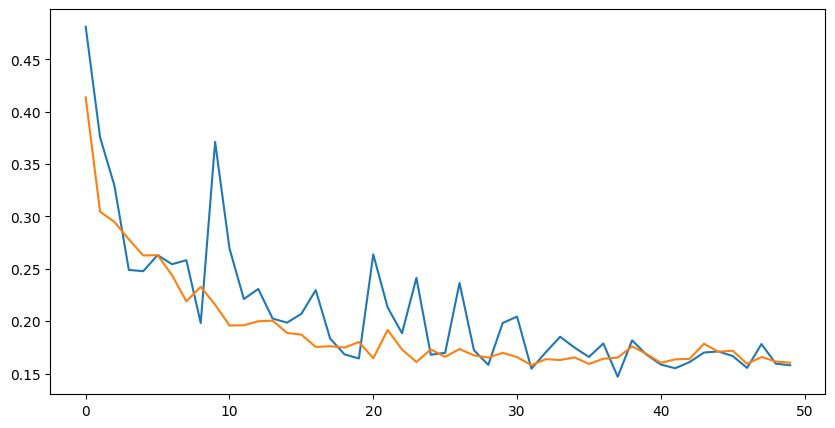

In [12]:
plt.figure(figsize= (10,5))
plt.plot(TrainLoss_list1)
plt.plot(val_losses)
#plt.show()

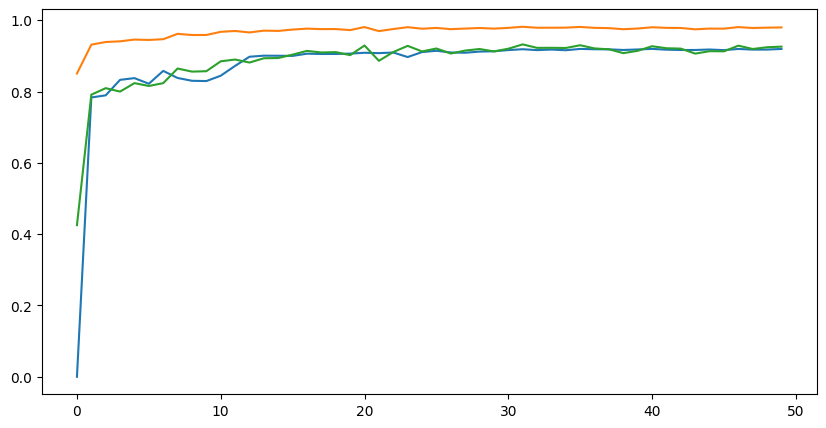

In [13]:
plt.figure(figsize= (10,5))
plt.plot(valScore_list1)
plt.plot(val_accs)
plt.plot(val_mious)
#plt.show()